In [1]:
import os
import datetime
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.optim as optim

import dataset

In [2]:
# Variables
DATASET_DIR = "../MIT_split/"
LABELS_DICT = {"Opencountry":0 ,  "coast":1,   "forest":2, "highway":3, "inside_city":4,  "mountain":5 , "street":6,  "tallbuilding":7}
MODEL_FNAME = 'model.h5'
BATCH_SIZE = 16
EPOCHS = 200
INPUT_SIZE = 64
EXPERIMENTS_PATH = 'experiments'


In [3]:
# check for CUDA availability
if torch.cuda.is_available():
    print('CUDA is available, setting device to CUDA')
# set device to  CUDA for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available, setting device to CUDA


In [4]:
##Instantiate Tensorboard Writer
#Create log folders
train_logdir = os.path.join(EXPERIMENTS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'train')
val_logdir = os.path.join(EXPERIMENTS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'validation')
#Create summary writer
train_writer = SummaryWriter(log_dir=train_logdir)
val_writer = SummaryWriter(log_dir=val_logdir)


In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
siamese_train_dataset, siamese_test_dataset, train_loader, test_loader = dataset.get_dataloaders(DATASET_DIR, INPUT_SIZE, BATCH_SIZE, kwargs)

In [6]:
# Set up the network and training parameters
from network import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    model.cuda()
criterion = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
log_interval = 100

In [7]:
from train import fit
fit(siamese_train_dataset, siamese_test_dataset, model, criterion, optimizer, scheduler, EPOCHS, cuda, log_interval)


/home/manelguz/miniconda3/envs/pytorch_env/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 0.180535
Train: [1600/1881 (85%)]	Loss: 0.165652
Epoch: 1/200. Train set: Average loss: 0.1624
Epoch: 1/200. Validation set: Average loss: 0.1400
Train: [0/1881 (0%)]	Loss: 0.154169
Train: [1600/1881 (85%)]	Loss: 0.164104
Epoch: 2/200. Train set: Average loss: 0.1643
Epoch: 2/200. Validation set: Average loss: 0.1446
Train: [0/1881 (0%)]	Loss: 0.182161
Train: [1600/1881 (85%)]	Loss: 0.149860
Epoch: 3/200. Train set: Average loss: 0.1505
Epoch: 3/200. Validation set: Average loss: 0.1408
Train: [0/1881 (0%)]	Loss: 0.112101
Train: [1600/1881 (85%)]	Loss: 0.145683
Epoch: 4/200. Train set: Average loss: 0.1453
Epoch: 4/200. Validation set: Average loss: 0.1193
Train: [0/1881 (0%)]	Loss: 0.105286
Train: [1600/1881 (85%)]	Loss: 0.137916
Epoch: 5/200. Train set: Average loss: 0.1372
Epoch: 5/200. Validation set: Average loss: 0.1223
Train: [0/1881 (0%)]	Loss: 0.173839
Train: [1600/1881 (85%)]	Loss: 0.132074
Epoch: 6/200. Train set: Average loss: 0.1332
Epoch: 6/200.

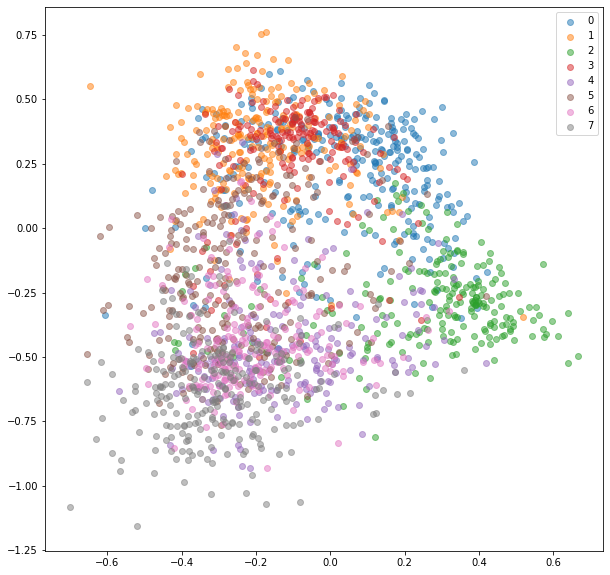

In [8]:
%matplotlib inline
from plot_emb import plot_embeddings, extract_embeddings
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images.float()).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
#val_embeddings_otl, val_labels_otl = extract_embeddings(siamese_test_dataset, model)
#plot_embeddings(val_embeddings_otl, val_labels_otl)